# Explore and Clean Brazilian Direct MySQL 

**Sources**: 
* MySQL database

**Goal**: The ultimate goal is to determine the most important features that predict whether a quote will convert to a purchase. The goal in this notebook is to explore the features available in the MySQL data and clean them up. Since many columns are categorical data, and I will ultimately be performing classification analyses, I'm going to try to merge the more unusual values into an `Other` label.

**MySQL Data Description**:
* `quote_id`: unique identifier for each quote
* `email`: email address associated with the quote
* `quote_status`: str indicating the current or final status of a quote; quotes that ultimately converted all have 'Converted' as their quote status, whereas quotes that did not convert fall into one of many reasons (e.g., lower price elsewhere)
* `date_created`: date the quote was created
* `days_until_needed`: number of days between quote creation date and the date the customer reported needing the product
* `urgency`: int indicating the urgency of the quote
* `phone_provided`: int indicating whether customer provided a phone number
* `ship_state`: state abbreviation (e.g., 'CA')
* `install_subfloor`: str indicating type of subfloor customer will install over
* `installation_needed`: int indicating whether customer requires installation
* `employee_id`: str indicating the employee handling the quote (e.g., 'DC')
* `sq_ft`: square footage requested in quote
* `cust_price`: price quoted to customer
* `retail_price`: retail price (determined by Dan?)
* `common_name`: species name
* `finish`: product finish (e.g., 'Prefinished')
* `grade`: product grade (i.e., quality)
* `milling`: product milling (e.g., 'Micro Bevel 4 Sides' ])
* `thickness`: product thickness - this column is not clean and contains duplicates (e.g., 3/4, 3/4")
* `width`: product width - this column is not clean and may contain multiple values (e.g., "3 or 3 1/4")
* `construction`: product construction (e.g., 'Solid') - there are multiple values that may want to merge (e.g., 'Solid' and 'Solid Long Lengths')
* `samples_avail`: int indicating whether samples are available for this product
* `accessories_avail`: int indicating whether accessories are available for this product
* `product_line`: str indicating the product line
* `product_line_category`: str, either 'HF' (hardwood floors), 'A' (accessories), 'V' (vents)

In [109]:
import MySQLdb
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import bd_mysql

sns.set();
%matplotlib inline

## Download MySQL data

In [110]:
config_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/cfg/mysql.cfg'
myDB = bd_mysql.connect_bd_mysql(config_path)

In [3]:
# Get quote data
quote_query = """
SELECT  q.quote_id, 
        c.email,
        sq.title AS quote_status,
        q.date_created, 
        DATEDIFF(q.date_needed, q.date_created) AS days_until_needed,
        q.urgency,
        CASE WHEN c.phone_home <> ""
             THEN 1
             ELSE 0
             END AS phone_provided,
        q.ship_state,
        q.install_subfloor,
        q.installation_needed,
        q.employee_id,
        ql.sq_ft,
        ql.cust_price,
        p.retail_price,
        s.common_name,
        p.finish,
        p.grade,
        p.milling,
        p.thickness,
        p.width,
        p.construction,
        p.samples_avail,
        p.accessories_avail, 
        pl.title AS product_line,
        pl.category_id AS product_line_category
FROM    brazdir_crm.quote q, 
        brazdir_crm.quote_line_item ql, 
        brazdir_crm.status_quote sq, 
        brazdir_crm.product p, 
        brazdir_crm.product_line pl,
        brazdir_crm.species s,
        brazdir_crm.contact c
WHERE   q.quote_id = ql.quote_id
AND     sq.status_quote_id = q.status_id
AND     ql.product_id = p.product_id
AND     p.product_line_id = pl.product_line_id
AND     p.species_id = s.species_id
AND     q.contact_id = c.contact_id
;
"""
quote_query = quote_query.replace('\n', ' ')

In [4]:
df = pd.read_sql(quote_query, myDB)

In [5]:
df.shape

(52372, 25)

## Clean MySQL data

In [6]:
df.head()

,quote_id,email,quote_status,date_created,days_until_needed,urgency,phone_provided,ship_state,install_subfloor,installation_needed,...,finish,grade,milling,thickness,width,construction,samples_avail,accessories_avail,product_line,product_line_category
0,081210150226,andy@modinds.com,Cancelled-Customer,2008-12-10 15:02:26,-338.0,2,1,AZ,Concrete,0,...,Prefinished,Clear,Micro Bevel 4 Sides,3/4,5,Solid,1,1,Classic Collection,HF
1,100524232259,scoulbourne@cs.com,Cancelled-NoResponse,2010-05-24 23:22:59,22.0,2,0,VA,Plywood,0,...,Prefinished,Clear,Micro Bevel 4 Sides,3/4,5,Solid,1,1,Classic Collection,HF
2,090921092443,tm1824@yahoo.com,Cancelled-Price,2009-09-21 09:24:43,0.0,2,0,NJ,Plywood,0,...,Prefinished,Clear,Micro Bevel 4 Sides,3/4,3,Solid,1,1,Classic Collection,HF
3,100105084629,tm1824@yahoo.com,Cancelled-Customer,2010-01-05 08:46:29,0.0,2,0,NJ,Plywood,0,...,Prefinished,Clear,Micro Bevel 4 Sides,3/4,4,Solid,1,1,Classic Collection,HF
4,070119035153,ybeckas@hotmail.com,Cancelled-Customer,2007-01-19 03:51:53,59.0,2,1,CA,Plywood,0,...,Prefinished,Clear,Micro Bevel 4 Sides,3/4,4 or 5,Solid,1,1,Classic Collection,HF


### Fix data types

In [7]:
df.dtypes

quote_id                         object
email                            object
quote_status                     object
date_created             datetime64[ns]
days_until_needed               float64
urgency                          object
phone_provided                    int64
ship_state                       object
install_subfloor                 object
installation_needed               int64
employee_id                      object
sq_ft                           float64
cust_price                      float64
retail_price                    float64
common_name                      object
finish                           object
grade                            object
milling                          object
thickness                        object
width                            object
construction                     object
samples_avail                     int64
accessories_avail                 int64
product_line                     object
product_line_category            object


In [8]:
# Convert quote_id to int
df['quote_id'] = df['quote_id'].astype(int)

In [9]:
# Convert urgency to float after replacing empty strings with np.nan
df.loc[df['urgency'] == "", 'urgency'] = np.nan
df['urgency'] = df['urgency'].astype(float)

## Examine numerical variables

In [10]:
df.describe(include=['int', 'float'])

,quote_id,days_until_needed,urgency,phone_provided,installation_needed,sq_ft,cust_price,retail_price,samples_avail,accessories_avail
count,5.237200e+04,52060.000000,52370.000000,52372.000000,52372.000000,52372.000000,50610.00000,52372.000000,52372.000000,52372.000000
mean,1.067064e+11,29.389301,2.103800,0.456198,0.007027,1352.650919,5.43334,7.872207,0.953315,0.968323
std,2.611091e+10,139.584560,0.312365,0.498082,0.083531,2123.795599,2.19922,1.386618,0.210966,0.175141
min,6.090609e+10,-2193.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,9.010312e+10,0.000000,2.000000,0.000000,0.000000,600.000000,4.89000,7.500000,1.000000,1.000000
50%,1.010242e+11,10.000000,2.000000,0.000000,0.000000,1000.000000,5.40000,8.500000,1.000000,1.000000
75%,1.302222e+11,31.000000,2.000000,1.000000,0.000000,1500.000000,5.87000,8.900000,1.000000,1.000000
max,1.603212e+11,4202.000000,3.000000,1.000000,1.000000,97058.000000,440.00000,16.990000,1.000000,1.000000


**Conclusions**: 
* There are some missing values and incorrect values for days_until_needed (can't have negative) so these need to be fixed
* There are very few non-zero values for `installation_needed`, so we can drop this variable
* There are some zero values for `cust_price` so these need to be dealt with
* There are also some very high values for `cust_price` -- these are likely either non-square footage prices or typos
* The vast majority of values for `samples_avail` and `accessories_avail` are 1, so can drop this variable

### Drop columns that have no variability

In [11]:
# Drop installation_needed, samples_avail, accessories_avail
df = df.drop(['installation_needed', 'samples_avail', 'accessories_avail'], axis=1)

In [12]:
# Replace days_until_needed < 1 with np.nan
df.loc[df['days_until_needed'] < 1, 'days_until_needed'] = np.nan

Based on the histogram above, I'm going to bin `days_until_needed` into 0-30, 31-60, 61-90, >90.

### Create binned versions of variables
* `days_until_needed`
* `sq_ft`

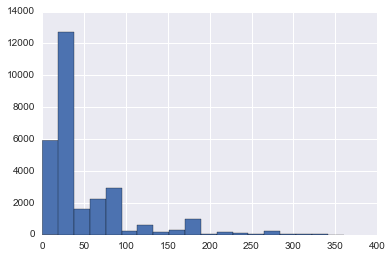

In [14]:
# Examine days_until_needed
df['days_until_needed'].hist(bins = np.linspace(0, 360, 20));

In [15]:
# bin days_until needed
bins = [0, 30, 60, 90, np.nanmax(df['days_until_needed'].values) + 1]
labels = ['0-30', '31-60', '61-90', '91+']
df['days_until_needed_bin'] = pd.cut(df['days_until_needed'], bins, labels=labels)

In [16]:
df['days_until_needed_bin'].value_counts(dropna=False)

NaN      23457
0-30     12313
31-60     8460
91+       5569
61-90     2573
dtype: int64

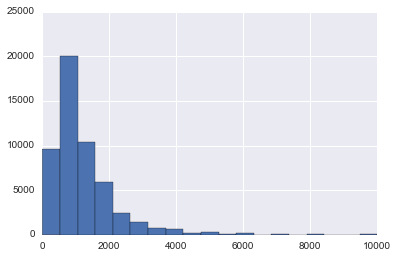

In [17]:
# Examine sq_ft
df['sq_ft'].hist(bins = np.linspace(0, 10000, 20));

In [18]:
# bin sq_ft
bins = [0, 500, 1000, 1500, 2000, 5000, max(df['sq_ft'].values) + 1]
labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-5000', '5001+']
df['sq_ft_bin'] = pd.cut(df['sq_ft'], bins, labels=labels)

In [19]:
df['sq_ft_bin'].value_counts(dropna=False)

501-1000     20101
1001-1500    10636
0-500         9059
2001-5000     6092
1501-2000     5776
5001+          705
NaN              3
dtype: int64

### Deal with outlier values for price

In [20]:
# Examine high values for 'cust_price'
df[['cust_price', 'retail_price', 'grade', 'width', 'construction']][df['cust_price'] > 20]

,cust_price,retail_price,grade,width,construction
35681,440.0,5.99,Premium/A,4 3/4,Engineered
39754,99.0,8.50,Clear,3 1/4,Solid
48754,100.0,8.50,Select & Better,3,Solid


Looks like the super high values for `cust_price` were typos, so we'll set them to np.nan.

In [21]:
# Replace zero values for customer price
df.loc[df['cust_price'] == 0, 'cust_price'] = np.nan

# Replace outlier values for customer price with np.nan
df.loc[df['cust_price'] > 20, 'cust_price'] = np.nan

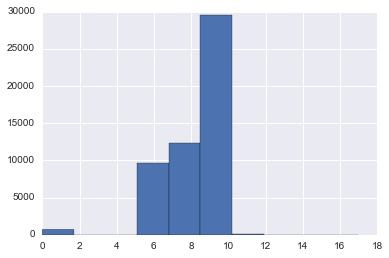

In [22]:
# Examine retail price
df['retail_price'].hist();

In [23]:
df['retail_price'].value_counts(dropna=False)

8.50     14866
8.95      7895
8.90      5770
6.50      4181
7.50      3981
7.80      3171
5.99      2387
7.70      1640
7.75      1623
5.50      1576
7.25      1295
9.50       889
6.29       762
0.00       727
7.00       580
6.00       543
6.49       145
10.95       96
8.55        87
8.99        54
7.95        53
7.65        38
4.50        10
13.99        2
16.99        1
Name: retail_price, dtype: int64

In [24]:
# Replace zero values for retail price
df.loc[df['retail_price'] == 0, 'retail_price'] = np.nan

## Examine categorical variables

In [25]:
df.describe(include=['object', 'datetime'])

,email,quote_status,date_created,ship_state,install_subfloor,employee_id,common_name,finish,grade,milling,thickness,width,construction,product_line,product_line_category
count,52372,52372,52371,52372,30914,52372,52372,52368,52368,52311,52368,52368,52368,52372,52372
unique,39446,14,52226,64,4,19,23,4,6,3,11,20,5,5,1
top,tonyk731@hotpop.com,Cancelled-Customer,2013-11-20 00:06:24,CA,Plywood,SO,Brazilian Cherry,Prefinished,Clear,Micro Bevel 4 Sides,3/4,3 1/4,Solid,Classic Collection,HF
freq,41,33990,5,6042,22254,21478,22094,40719,45867,40738,48693,12720,48936,51955,52372
first,NaN,NaN,2006-09-06 07:37:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-03-21 20:22:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusions**:
* Nearly all values for `product_line` and `product_line_category` are identical, so drop them
* `date_created` is too precise for my needs (includes timestamp)
* More than 50 values for `ship_state` -- what are the others?

### Drop columns with no variability

In [26]:
# drop product_line and product_line_category
df = df.drop(['product_line', 'product_line_category'], axis=1)

### Create a column for whether quote converted

In [27]:
# Create a column for whether the quote converted
df['converted'] = np.where(df['quote_status'] == 'Converted', 1, 0)

In [28]:
df['converted'].value_counts()

0    49512
1     2860
Name: converted, dtype: int64

### Examine reasons why quotes did not convert

In [29]:
df['quote_status'].value_counts(dropna=False)

Cancelled-Customer           33990
Cancelled-NoResponse         10653
Converted                     2860
Cancelled-Other               2447
Active                        1972
Cancelled-Sendgrid-Unsub       173
Cancelled-Price                144
Cancelled-OtherProduct          36
Quoted                          33
Cancelled-Sendgrid-Spam         28
Cancelled-TooSmall              21
Cancelled-NoInventory            9
Cancelled-Sendgrid-Bounce        5
Unanswered                       1
Name: quote_status, dtype: int64

We don't really have any useful data here, just cancelled by customer either actively (`Cancelled-Customer`) or passively (`Cancelled-NoResponse`), so drop this column.

In [30]:
# drop quote_status
df = df.drop('quote_status', axis=1)

### Create date grouping variables

In [31]:
# Drop timestamp from date_created
df['date_created'] = [x.date() for x in df['date_created']]

In [32]:
# Create columns for month and year
df['month'] = [x.month for x in df['date_created']]
df['year'] = [x.year for x in df['date_created']]

### Examine conversions by year

In [33]:
pd.crosstab(df['year'], df['converted'])

converted,0,1
year,,
2006.0,1434,1
2007.0,5190,8
2008.0,6262,165
2009.0,7016,451
2010.0,6362,474
2011.0,5746,378
2012.0,4687,356
2013.0,3938,365
2014.0,3930,368


**Conclusions**: It looks like maybe the database wasn't correctly storing the conversion data for the earliest years since 2007 has 5190 quotes but only 8 conversions. I suspect this must have been corrected by 2009 because the conversions come up to a more expected level.

Since I don't seem to have reliable data for the early years, I'll exclude quotes prior to 2009.

There's also a surprising drop in conversions for 2015. Even though quotes were overall higher than the previous year, conversions were much lower.

In [34]:
# Filter out quotes pre-2009
df = df[df['year'] >= 2009]

In [35]:
df.shape

(39311, 24)

### Examine quotes by month

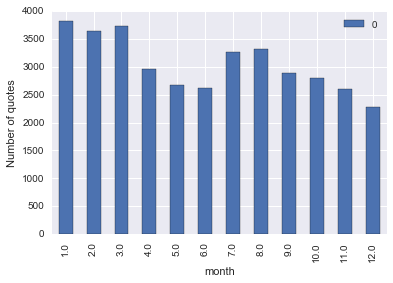

In [36]:
# Plot quotes by month
xt = pd.crosstab(df['month'], df['converted']).reset_index()
xt.plot.bar('month', 0);
plt.ylabel('Number of quotes');
plt.ylim([0,4000]);

**Conclusions**: Quotes are highest during the first and third quarters. 

### Examine conversions by month

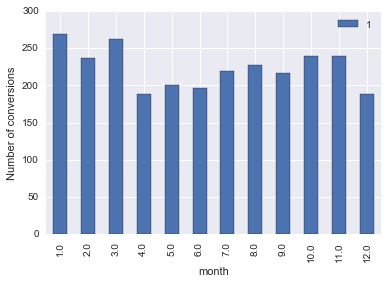

In [37]:
# Plot conversions by month
xt = pd.crosstab(df['month'], df['converted']).reset_index()
xt.plot.bar('month', 1);
plt.ylabel('Number of conversions');
plt.ylim([0,300]);

**Conclusions**: Conversions are highest during the first quarter and lowest during the second quarter.

### Handle messy labels

#### ship_state
Why are there more than 50 states?

In [39]:
df['ship_state'].value_counts()

CA    4557
NY    2990
NJ    2809
PA    2445
FL    2019
IL    1916
VA    1705
TX    1519
MI    1374
MD    1330
MA    1247
OH    1245
WA    1200
NC    1149
GA     888
       778
CO     743
TN     695
IN     691
MO     649
SC     599
MN     564
CT     536
WI     482
OR     424
KY     413
LA     384
AL     344
AZ     291
NH     253
      ... 
RI     202
NV     182
ME     172
KS     171
HI     160
VT     114
OK     102
MS     100
AK      98
AR      95
ID      90
DC      89
MT      87
ND      82
NE      80
NM      66
ON      63
WY      59
SD      54
AB      45
QC      31
BC      29
NB       6
SK       6
MB       4
NS       3
--       2
NL       1
md       1
NT       1
Name: ship_state, dtype: int64

Looks like there are some Canadian provinces as well as some missing values.

In [40]:
# Change md to MD
df.loc[df['ship_state'] == 'md', 'ship_state'] = 'MD'

# Replace -- and '' with MISSING
df.loc[df['ship_state'] == '', 'ship_state'] = 'MISSING'
df.loc[df['ship_state'] == '--', 'ship_state'] = 'MISSING'

#### install_subfloor

In [42]:
# Examine values for install_subfloor
df['install_subfloor'].value_counts()

Plywood     12789
Concrete     3748
Other         995
              322
Name: install_subfloor, dtype: int64

In [43]:
# Merge missing values with other
df.loc[df['install_subfloor'] == '', 'install_subfloor'] = 'Other'

#### employee_id

In [46]:
df['employee_id'].value_counts()

SO     15604
NP     12326
DC      7589
        1204
SF      1120
TW       795
JO       362
BV       157
EDL       84
JP        52
MS        12
TC         2
RC         1
JV         1
LM         1
SB         1
Name: employee_id, dtype: int64

The vast majority of quotes are handled by `SO`, `NP`, and `DC`. `NP` no longer works with the company, but it is still worth modeling since it makes sure a large proportion of the historical data. I'll merge all the remaining values into `OTHER`.

In [48]:
# Merge values into OTHER
df.loc[~df['employee_id'].isin(['SO', 'NP', 'DC']), 'employee_id'] = 'OTHER'

In [49]:
df['employee_id'].value_counts()

SO       15604
NP       12326
DC        7589
OTHER     3792
Name: employee_id, dtype: int64

#### common_name

In [56]:
# Crosstabulate species by converted
xt_species = pd.crosstab(df['common_name'], df['converted']).reset_index()
xt_species

converted,common_name,0,1
0,African Mahogany,1,0
1,Amendoim,1351,124
2,American Walnut,1,0
3,Brazilian Cherry,15360,984
4,Brazilian Teak,4799,445
5,Brazilian Walnut,4461,280
6,Caribbean Heart Pine,48,4
7,Guajara,157,6
8,Hard Maple,1,0
9,Hickory,3,0


**Conclusions**: Most of the species have very few conversions. I'll group all the ones with < 50 conversions into the `Other` category.

In [60]:
# identify species with < 50 conversions
conversion_thresh = 50
other_species = list(xt_species.loc[xt_species[1] < conversion_thresh, 'common_name'])

In [62]:
# merge labels
df.loc[df['common_name'].isin(other_species), 'common_name'] = 'Other'

In [63]:
df['common_name'].value_counts()

Brazilian Cherry       16344
Brazilian Teak          5244
Brazilian Walnut        4741
Santos Mahogany         4398
Tigerwood               3864
Amendoim                1475
Tiete Rosewood          1363
Other                    991
Patagonian Rosewood      891
Name: common_name, dtype: int64

#### finish

In [66]:
df['finish'].value_counts(dropna=False)

Prefinished            30685
Unfinished              8153
                         417
Prefinished Natural       56
Name: finish, dtype: int64

I'm going to merge `Prefinished Natural` into `Prefinished`.

In [67]:
# relabel Prefinished Natural
df.loc[df['finish'] == 'Prefinished Natural', 'finish'] = 'Prefinished'

# label missing data
df.loc[df['finish'] == '', 'finish'] = 'Missing'

In [68]:
df['finish'].value_counts(dropna=False)

Prefinished    30741
Unfinished      8153
Missing          417
Name: finish, dtype: int64

#### grade

In [69]:
df['grade'].value_counts(dropna=False)

Clear              33819
Premium/A           2317
Select & Better     1842
                     891
Select               387
Rustic                55
Name: grade, dtype: int64

I'll merge `Select` into `Select & Better` and merge `Rustic` into a missing label.

In [70]:
# relabel Select
df.loc[df['grade'] == 'Select', 'grade'] = 'Select & Better'

# relabel Rustic
df.loc[df['grade'] == 'Rustic', 'grade'] = 'Missing'

# relabel empty
df.loc[df['grade'] == '', 'grade'] = 'Missing'

In [71]:
df['grade'].value_counts(dropna=False)

Clear              33819
Premium/A           2317
Select & Better     2229
Missing              946
Name: grade, dtype: int64

#### milling

In [72]:
df['milling'].value_counts(dropna=False)

Micro Bevel 4 Sides    30679
Square Edges            7875
                         700
NaN                       57
Name: milling, dtype: int64

Merge NaN and no label data into `Missing` category.

In [85]:
# create missing label
df.loc[df['milling'] == '', 'milling'] = 'Missing'

# relabel nan
df['milling'] = df['milling'].fillna(value = 'Missing')

In [86]:
df['milling'].value_counts(dropna=False)

Micro Bevel 4 Sides    30679
Square Edges            7875
Missing                  757
Name: milling, dtype: int64

#### thickness

In [87]:
df['thickness'].value_counts(dropna=False)

3/4           35667
1/2            1263
9/16           1158
3/8             790
4/4 or 5/4      325
3/4"             48
 3/4             21
 3/8             18
 1/2             11
7/16             10
Name: thickness, dtype: int64

First, let's strip the whitespace and remove ".

In [88]:
df['thickness'] = [x.strip().replace('"', '') if x is not None and x != '' else np.nan for x in df['thickness'] ]
df['thickness'].value_counts(dropna=False)

3/4           35736
1/2            1274
9/16           1158
3/8             808
4/4 or 5/4      325
7/16             10
Name: thickness, dtype: int64

Let's look at some of the more obscure thicknesses.

In [94]:
df.loc[df['thickness'] == '7/16', ['common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,common_name,finish,grade,construction
44155,Other,Prefinished,Missing,Solid


In [95]:
df.loc[df['thickness'] == '4/4 or 5/4', ['common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,common_name,finish,grade,construction
3033,Brazilian Walnut,Missing,Select & Better,


In [96]:
df.loc[df['thickness'] == '3/8', ['common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,common_name,finish,grade,construction
48,Brazilian Cherry,Prefinished,Clear,Solid
78,Other,Prefinished,Clear,Engineered
2900,Brazilian Cherry,Prefinished,Clear,Engineered
24441,Tigerwood,Prefinished,Clear,Solid
42174,Tigerwood,Prefinished,Premium/A,Engineered


In [97]:
df.loc[df['thickness'] == '9/16', ['common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,common_name,finish,grade,construction
10,Brazilian Cherry,Prefinished,Clear,Engineered
3572,Tigerwood,Prefinished,Clear,Engineered
12191,Other,Prefinished,Missing,Engineered
28873,Brazilian Cherry,Prefinished,Select & Better,Engineered


In [98]:
df.loc[df['thickness'] == '1/2', ['common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,common_name,finish,grade,construction
64,Tigerwood,Prefinished,Premium/A,Engineered
91,Brazilian Cherry,Prefinished,Premium/A,Engineered
139,Santos Mahogany,Prefinished,Premium/A,Engineered
4028,Other,Prefinished,Premium/A,Engineered
9816,Other,Prefinished,Premium/A,Engineered Click
43152,Santos Mahogany,Prefinished,Select & Better,Engineered
48364,Brazilian Cherry,Prefinished,Select & Better,Engineered
48540,Amendoim,Prefinished,Premium/A,Engineered


In contrast, here's the most common thickness.

In [99]:
df.loc[df['thickness'] == '3/4', ['common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,common_name,finish,grade,construction
1,Tigerwood,Prefinished,Clear,Solid
2,Brazilian Teak,Prefinished,Clear,Solid
3,Santos Mahogany,Prefinished,Clear,Solid
5,Brazilian Cherry,Prefinished,Clear,Solid
9,Amendoim,Prefinished,Select & Better,Solid
13,Brazilian Cherry,Unfinished,Clear,Solid
15,Brazilian Teak,Unfinished,Clear,Solid
27,Brazilian Walnut,Prefinished,Clear,Solid
75,Patagonian Rosewood,Unfinished,Missing,Solid
76,Tiete Rosewood,Prefinished,Premium/A,Solid


Since there are only a handful of products that fall into the other thicknesses, I'm just going to drop this variable.

In [100]:
# drop thickness
df = df.drop('thickness', axis=1)

#### width

In [101]:
df['width'].value_counts(dropna=False)

5             11261
3 1/4         10750
3              7851
4              6926
4 3/4          1296
2 1/4           371
4" or 6"        325
5", 6", 7"      299
3 5/8            91
3,4,5            40
5                30
5.5", 7"         26
3" - 8"          22
3 3/4            12
5 1/4             5
5,6,7,or 8        4
4                 2
Name: width, dtype: int64

Same as for thickness, we'll strip whitespace and drop ".

In [102]:
df['width'] = [x.strip().replace('"', '') if x is not None and x != '' else np.nan for x in df['width'] ]
df['width'].value_counts(dropna=False)

5             11291
3 1/4         10750
3              7851
4              6928
4 3/4          1296
2 1/4           371
4 or 6          325
5, 6, 7         299
3 5/8            91
3,4,5            40
5.5, 7           26
3 - 8            22
3 3/4            12
5 1/4             5
5,6,7,or 8        4
Name: width, dtype: int64

Let's look at the less common widths.

In [103]:
weird_width = ['2 1/4', '4 or 6', '5, 6, 7', '3 5/8', '3,4,5', '5.5, 7', '3 - 8', '3 3/4', '5 1/4', '5,6,7,or 8']
df.loc[df['width'].isin(weird_width), ['width', 'common_name', 'finish', 'grade', 'construction']].drop_duplicates()

,width,common_name,finish,grade,construction
114,2 1/4,Brazilian Cherry,Prefinished,Clear,Solid
269,"5, 6, 7",Brazilian Cherry,Unfinished,Clear,Solid Long Lengths
2887,3 - 8,Other,Missing,Select & Better,Engineered
3033,4 or 6,Brazilian Walnut,Missing,Select & Better,
5305,3 5/8,Other,Prefinished,Clear,Solid
29011,"3,4,5",Brazilian Walnut,Missing,Select & Better,Solid Long Lengths
31044,"3,4,5",Other,Missing,Select & Better,Solid Long Lengths
31108,3 - 8,Santos Mahogany,Missing,Select & Better,Engineered
31123,"5.5, 7",Other,Missing,Clear,Solid
31125,"5,6,7,or 8",Other,Missing,Missing,Solid Long Lengths


In [104]:
# cross tab on weird widths
pd.crosstab(df['width'].isin(weird_width), df['converted'])

converted,0,1
width,,
False,35478,2638
True,1148,47


Since there are very few quotes/conversions for weird widths, I'll merge them into `Other`.

In [105]:
# merge weird widths
df.loc[df['width'].isin(weird_width), 'width'] = 'Other'
df['width'].value_counts(dropna=False)

5        11291
3 1/4    10750
3         7851
4         6928
4 3/4     1296
Other     1195
Name: width, dtype: int64

#### construction

In [106]:
df['construction'].value_counts(dropna=False)

Solid                 35887
Engineered             2719
Solid Long Lengths      343
                        325
Engineered Click         37
Name: construction, dtype: int64

I'm going to merge `Engineered Click` into `Engineered`, merge `Solid Long Lengths` into `Solid`, and give the empty data a `Missing` label.

In [107]:
# relabel Engineered Click
df.loc[df['construction'] == 'Engineered Click', 'construction'] = 'Engineered'

# relabel Solid Long Lengths
df.loc[df['construction'] == 'Solid Long Lengths', 'construction'] = 'Solid'

# relabel ''
df.loc[df['construction'] == '', 'construction'] = 'Missing'

In [108]:
df['construction'].value_counts(dropna=False)

Solid         36230
Engineered     2756
Missing         325
Name: construction, dtype: int64

In [64]:
df.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'urgency', u'phone_provided', u'ship_state', u'install_subfloor',
       u'employee_id', u'sq_ft', u'cust_price', u'retail_price',
       u'common_name', u'finish', u'grade', u'milling', u'thickness', u'width',
       u'construction', u'days_until_needed_bin', u'sq_ft_bin', u'converted',
       u'month', u'year'],
      dtype='object')

## Visualize distributions of variables based on conversion

In [85]:
vis_vars = ['days_until_needed', 'urgency', 'sq_ft', 'cust_price', 'retail_price']

In [87]:
def conversion_hist(column_name, bins):
    plt.figure();
    df.groupby('converted')[column_name].plot.hist(bins=bins, alpha = 0.5);
    plt.legend(loc='best');
    plt.title(column_name);

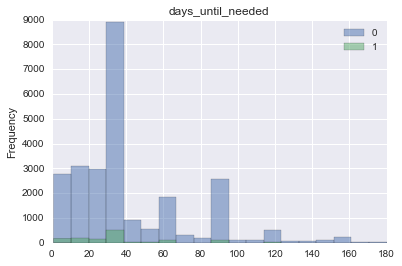

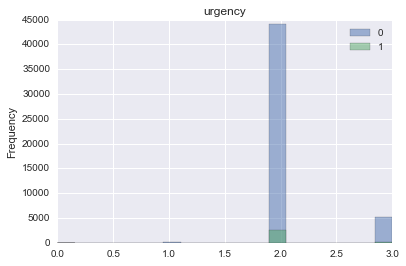

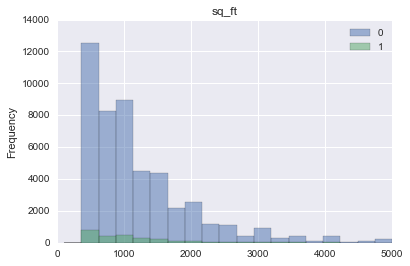

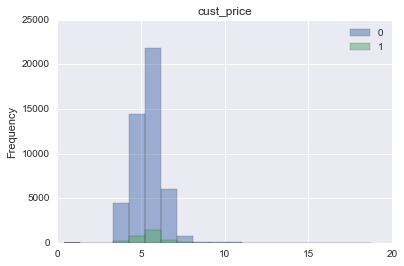

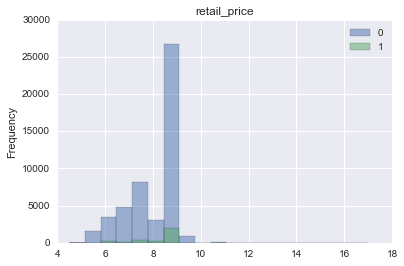

In [91]:
for column in vis_vars:
    if column == 'days_until_needed':
        bins = np.linspace(1, 180, 20)
    elif column == 'sq_ft':
        bins = np.linspace(100, 5000, 20)
    else:
        bins = np.linspace(min(df[column]),
                      max(df[column]),
                         20)
    conversion_hist(column, bins)

**Conclusions**: 
* Distributions for converted and not appear pretty similar for these variables
* `retail_price` does not seem to be reliable since there is a massive spike (possible default value?); since it wasn't clear where this data came from, I think it's safe to drop it

In [93]:
# Drop retail_price column
df = df.drop('retail_price', axis=1)

In [174]:
def conversion_barplot(column, df):
    
    # calculate crosstabs
    xt = pd.crosstab(df[column], df['converted'], dropna=False).reset_index()
    xt.columns = [column, 'no_conversion', 'conversion']
    
    # convert from counts to percent
    xt_sum = xt.sum(numeric_only=True, axis=0)
    xt[['conversion', 'no_conversion']] = xt[['conversion', 'no_conversion']].div(xt_sum) * 100
    
    # melt to long format
    xt = pd.melt(xt, id_vars = column)
    
    # plot results
    p = sns.barplot(x = xt[column], y = xt['value'], hue = xt['variable']);
    for x in p.get_xticklabels():
        x.set_rotation(90);
    plt.ylabel('Percent');
    plt.title(column)

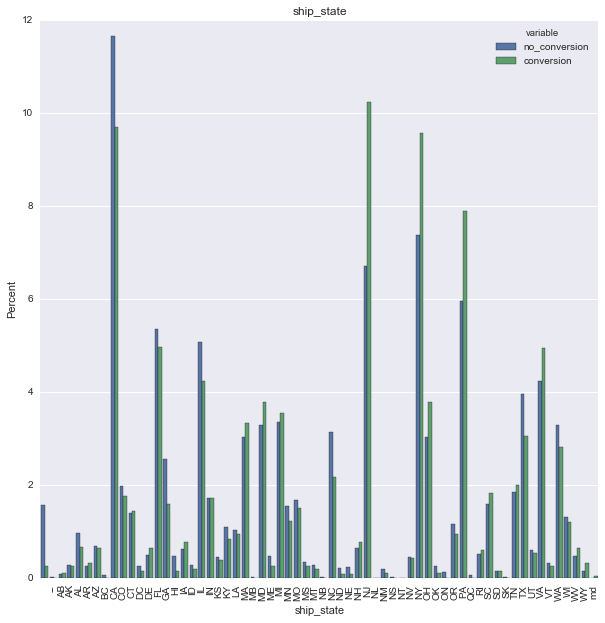

In [185]:
plt.figure(figsize = (10,10))
conversion_barplot('ship_state', df)

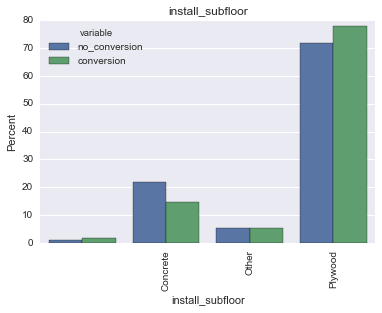

In [186]:
conversion_barplot('install_subfloor', df)

In [332]:
np.unique(df['install_subfloor'].values)

array([None, '', 'Concrete', 'Other', 'Plywood'], dtype=object)

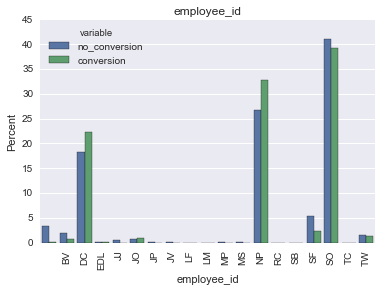

In [187]:
conversion_barplot('employee_id', df)

In [333]:
np.unique(df['employee_id'].values)

array(['', 'BV', 'DC', 'EDL', 'JJ', 'JO', 'JP', 'JV', 'LF', 'LM', 'MP',
       'MS', 'NP', 'RC', 'SB', 'SF', 'SO', 'TC', 'TW'], dtype=object)

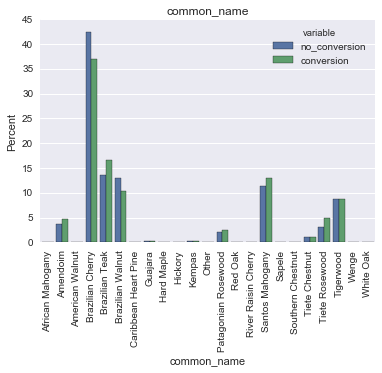

In [188]:
conversion_barplot('common_name', df)

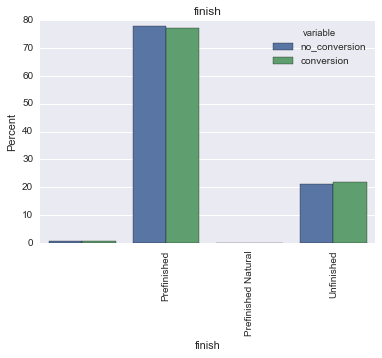

In [189]:
conversion_barplot('finish', df)

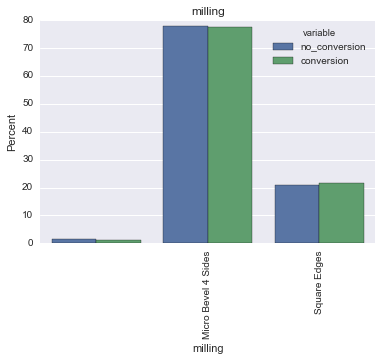

In [190]:
conversion_barplot('milling', df)

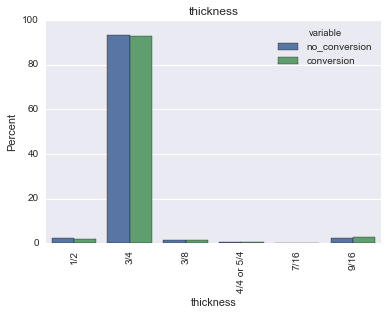

In [191]:
conversion_barplot('thickness', df)

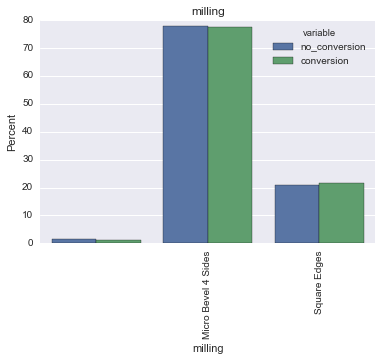

In [192]:
conversion_barplot('milling', df)

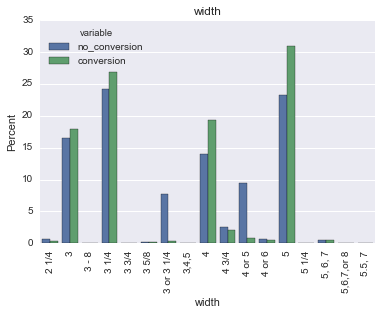

In [193]:
conversion_barplot('width', df)

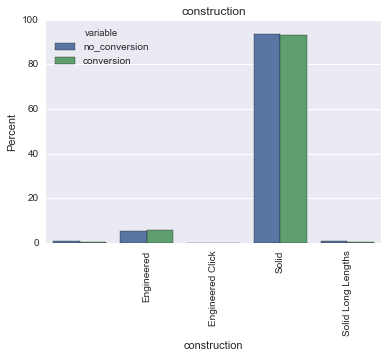

In [198]:
conversion_barplot('construction', df)

## Preprocess data for sklearn

In [254]:
# Examine number of missing values in each column
for col in df.columns:
    print col, ': ', df[col].isnull().sum()

quote_id :  0
email :  0
quote_status :  0
date_created :  1
days_until_needed :  23450
urgency :  0
ship_state :  0
install_subfloor :  21442
employee_id :  0
sq_ft :  0
cust_price :  1775
common_name :  0
finish :  4
grade :  4
milling :  61
thickness :  11
width :  11
construction :  4
converted :  0


We'll impute with the median value for the numerical columns that are missing data (`days_until_needed` and `cust_price`) and impute with the mode value for missing categorical data.

In [258]:
from sklearn.preprocessing import Imputer

In [259]:
# column types
cat_columns = ['urgency', 'ship_state', 'install_subfloor', 'employee_id', 'common_name', 'finish', 'grade', 'milling', 'thickness', 'width', 'construction']
meas_columns = ['days_until_needed', 'sq_ft', 'cust_price']

In [260]:
# Extract categorical variables
X_cat = df.as_matrix(columns=cat_columns)

# Extract measured variables
X_meas = df.as_matrix(columns=meas_columns)

In [263]:
# Impute measured variables
imp_meas = Imputer(missing_values=np.nan, strategy='median', axis=0)

# Fit imputer
imp_meas.fit(X_meas)

# Impute values
X_meas_imp = imp_meas.transform(X_meas)

In [265]:
# Before imputing categorical data, need to convert from strings to 0-indexed integers
from sklearn.preprocessing import LabelEncoder
labels = {}
for i, col in enumerate(cat_columns):
    
    # Extract the column values and convert to 0-indexed integers
    x = X_cat[:, i]
    le = LabelEncoder().fit(x)
    X_cat[:, i] = le.transform(x)
    
    # Store label data
    labels[col] = le

In [266]:
# Impute categorical variables
imp_cat = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)

# Fit imputer
imp_cat.fit(X_cat)

# Impute values
X_cat_imp = imp_cat.transform(X_cat)

In [268]:
# Use one-hot encoding to transform categorical variable into
# multiple binary variables
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(X_cat_imp)

# Apply one-hot encoding
X_cat_imp = enc.transform(X_cat_imp).toarray()

In [270]:
# scale measure features
from sklearn.preprocessing import scale
X_meas_imp = scale(X_meas_imp)

In [271]:
# Concatenate features
feature_type = ['cat'] * X_cat_imp.shape[1] + ['meas'] * X_meas_imp.shape[1]
X = np.concatenate((X_cat_imp, X_meas_imp), axis=1)

In [272]:
y = df.as_matrix(columns=['converted'])

## Prepare cross-validation using stratified k-fold

In [273]:
from sklearn.cross_validation import StratifiedShuffleSplit

In [299]:
sss = StratifiedShuffleSplit(y.ravel(), 10, test_size=0.33)

## Fit parameters for random forest

In [287]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

In [282]:
# Build separate training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=0, stratify = y)

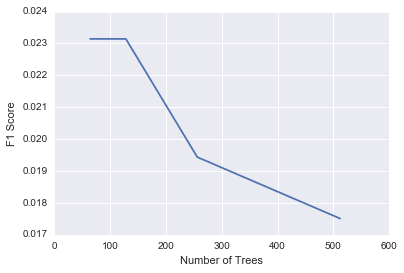

In [288]:
# Optimize number of trees
num_trees = [64, 128, 256, 512]
scores = []
for tree_size in num_trees:
    clf = RandomForestClassifier(n_estimators=tree_size, 
                                 oob_score=True,
                                 class_weight = 'balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(num_trees, scores);
plt.xlabel('Number of Trees');
plt.ylabel('F1 Score');

In [293]:
best_tree_size = num_trees[scores.index(max(scores))]

In [294]:
X.shape

(52356, 165)

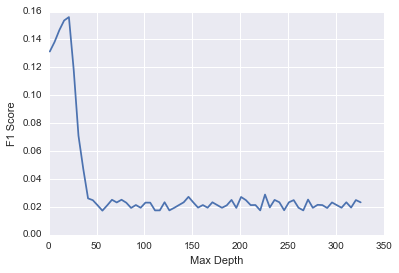

In [295]:
# Optimize parameters of Random Forest
max_depth = range(1, X.shape[1]*2, 5)
num_trees = best_tree_size
scores = []
for depth in max_depth:
    clf = RandomForestClassifier(n_estimators=num_trees, 
                                 oob_score=True, 
                                 max_depth = depth,
                                class_weight = 'balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(max_depth, scores);
plt.xlabel('Max Depth');
plt.ylabel('F1 Score');
best_depth = max_depth[scores.index(max(scores))]

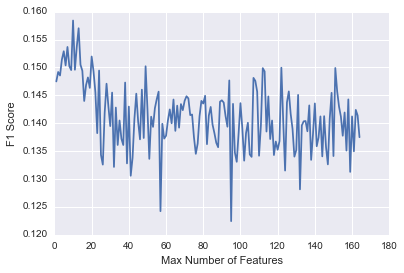

In [296]:
# Optimize number of features
num_trees = best_tree_size
max_depth = best_depth
num_features = range(1, X.shape[1])
scores = []
for num in num_features:
    clf = RandomForestClassifier(n_estimators=num_trees,
                                oob_score = True,
                                max_depth = max_depth,
                                max_features = num,
                                class_weight = 'balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(num_features, scores);
plt.xlabel('Max Number of Features');
plt.ylabel('F1 Score');
best_features = num_features[scores.index(max(scores))]

In [302]:
scores = []
for train_index, test_index in sss:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].ravel(), y[test_index].ravel()
    
    rf = RandomForestClassifier(n_estimators=best_tree_size,
                                oob_score = True,
                                max_depth = best_depth,
                                max_features = best_features,
                                class_weight = 'balanced')
    rf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
print np.mean(scores)
    

0.449896821348


In [305]:
from sklearn import metrics
le = LabelEncoder().fit(y.ravel())
print metrics.classification_report(y_test, y_pred, target_names=[str(x) for x in le.classes_])

             precision    recall  f1-score   support

          0       0.98      0.92      0.95     16335
          1       0.34      0.71      0.46       943

avg / total       0.95      0.91      0.92     17278



In [308]:
# Get the order of features in descending order
feature_order = list(np.argsort(rf.feature_importances_)[::-1])

In [320]:
top_10_features_indices = [feature_order.index(x) for x in range(10)]
top_10_features_indices

[145, 101, 22, 27, 24, 160, 113, 96, 73, 103]

In [324]:
meas_columns

['days_until_needed', 'sq_ft', 'cust_price']

In [325]:
labels

{'common_name': LabelEncoder(),
 'construction': LabelEncoder(),
 'employee_id': LabelEncoder(),
 'finish': LabelEncoder(),
 'grade': LabelEncoder(),
 'install_subfloor': LabelEncoder(),
 'milling': LabelEncoder(),
 'ship_state': LabelEncoder(),
 'thickness': LabelEncoder(),
 'urgency': LabelEncoder(),
 'width': LabelEncoder()}

In [327]:
labels['install_subfloor'].classes_

array([None, '', 'Concrete', 'Other', 'Plywood'], dtype=object)